In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import plotly.express as px
import plotly.graph_objects as go
import itertools
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from diffusers import DDPMScheduler
import matplotlib.pyplot as plt

import sys
sys.path.insert(1,"../scripts")
from get_voxels import get_mol_voxels
from networks import Encoder, UNet3D

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

encoder = Encoder()
encoder.to(device)

encoder.load_state_dict(torch.load("../models/state_dict_encoder.pt"))

Using device: cuda


<All keys matched successfully>

## Get list of smiles

In [3]:
smiles = []
with open("../datasets/raw/zinc15_druglike_clean_canonical_max60.smi") as f:
    i=0
    for i, line in enumerate(f):
        smiles.append(line)
        if i > 250000:
            break

smiles = smiles[216000:]

# inputs = []
# targets = []

# for i in range(len(smiles)):
#     try:
#         inp, targ = get_mol_voxels(smiles[i])
#         inputs.append(inp)
#         targets.append(targ)
#     except:
#         continue

# inputs = torch.stack(inputs)
# targets = torch.stack(targets)

# with open("input.sav","wb") as f:
#     torch.save(inputs, f)

# with open("target.sav","wb") as f:
#     torch.save(targets, f)

## Set up custom dataloader with vox encoding

Collate_bach generates vox representations on the fly, prevent kernel crash due to being out of memory

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, smiles):
        self.transform = get_mol_voxels
        self.smiles = smiles

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = self.smiles[idx]
        return smile

smile_DS = CustomImageDataset(smiles)

def collate_batch(smiles):
    inputs = []
    target = []
    for smile in smiles:
        try:
            rep, pharm = get_mol_voxels(smile)
            inputs.append(rep)
            target.append(pharm)
        except:
            continue

    return torch.stack(inputs), torch.stack(target)

In [5]:
# Dataloader (you can mess with batch size)
train_dataloader = DataLoader(smile_DS, batch_size=128, collate_fn=collate_batch)

# How many runs through the data should we do?
n_epochs = 1

# Our loss finction
criterion = nn.MSELoss()
# The optimizer
optimizer = torch.optim.Adam(encoder.parameters())

# Keeping a record of the losses for later viewing
losses_enc = []

# Initialize the DDPM scheduler
ddpm = DDPMScheduler(num_train_timesteps=1000)

In [6]:
for epoch in range(n_epochs):
    
    for i, (x, targets) in enumerate(train_dataloader):
        x = x.to(device)
        targets = targets.to(device)

        # Forward pass
        encoded_tensor = encoder(x)
        loss = criterion(encoded_tensor, targets)
        losses_enc.append(loss.cpu().detach().numpy())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i%100 == 0:
            torch.save(encoder.state_dict(), "../models/state_dict_encoder.pt")

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses_enc[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average enc loss for this epoch: {avg_loss:05f}')#

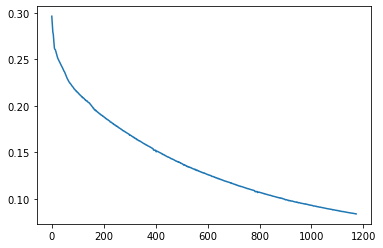

In [12]:
import matplotlib.pyplot as plt

plt.plot(losses_enc)

## Train the unet

Ideally would train both at the same time, but memory becomes an issue - running on a laptop with only 4GB gpu ram

In [5]:
net = UNet3D(in_channels=5, num_classes=5)
net.to(device)

net.load_state_dict(torch.load("../models/state_dict_net.pt"))

<All keys matched successfully>

In [6]:
# How many runs through the data should we do?
n_epochs = 1

train_dataloader = DataLoader(smile_DS, batch_size=32, collate_fn=collate_batch)

# Our loss finction
loss_fn = nn.BCELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=0.001) 

# Keeping a record of the losses for later viewing
losses_net = []
# Initialize the DDPM scheduler
ddpm = DDPMScheduler(num_train_timesteps=1000)

In [7]:
for epoch in range(n_epochs):
    
    for i, (x, targets) in enumerate(train_dataloader):
        timesteps = torch.randint(
            0,
            ddpm.num_train_timesteps,
            (x.shape[0],),
            device=x.device,
        ).long()

        noise = torch.randn(x.shape).to(x.device)
        noisy_x = ddpm.add_noise(x, noise, timesteps)


        noisy_x = noisy_x.type(torch.FloatTensor).to(device)

        x = x.to(device) # Data on the GPU
        # Get the model prediction

        pred = net(noisy_x)

        # Calculate the loss
        
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        losses_net.append(loss.cpu().detach().numpy())

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        if i%500 == 0:
            torch.save(net.state_dict(), "../models/state_dict_net.pt")
            print("500 batches done")


    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses_net[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses_net)

500 batches done
Gen_rep_fails
Gen_rep_fails
Gen_rep_fails
500 batches done


KeyboardInterrupt: 